In [1]:
push!(LOAD_PATH,"../../../ExoJulia/")
push!(LOAD_PATH,".")

4-element Array{ByteString,1}:
 "/Applications/Julia-0.4.5.app/Contents/Resources/julia/local/share/julia/site/v0.4"
 "/Applications/Julia-0.4.5.app/Contents/Resources/julia/share/julia/site/v0.4"      
 "../../../ExoJulia/"                                                                
 "."                                                                                 

In [2]:
using ExoJulia
using Optim

In [21]:
using PyPlot

# Read-in TTV data

In [3]:
ttv1_data = readdlm("../ttv_planet1.txt");
ttv2_data = readdlm("../ttv_planet2.txt");

In [9]:
# Reshape into 1d arrays
time1 = reshape(ttv1_data, length(ttv1_data));
time2 = reshape(ttv2_data, length(ttv2_data));

In [45]:
dt1 = time1[2:end] - time1[1:end-1];
dt2 = time2[2:end] - time2[1:end-1];

mdt1 = mean(dt1);
mdt2 = mean(dt2);

stdt1 = std(dt1);
stdt2 = std(dt2);

print("Inner planet period: ", mdt1, " +/- ", stdt1, "\n")
print("Outer planet period: ", mdt2, " +/- ", stdt2)

Inner planet period: 224.70076641863517 +/- 0.0022854502193227965
Outer planet period: 365.25630708152175 +/- 0.002178896306975526

# Plot data

In [69]:
a = ones(length(time1))
b = zeros(length(time1))
for i=1:length(time1)
    a[i] = i*mdt1
    b[i] = i
end

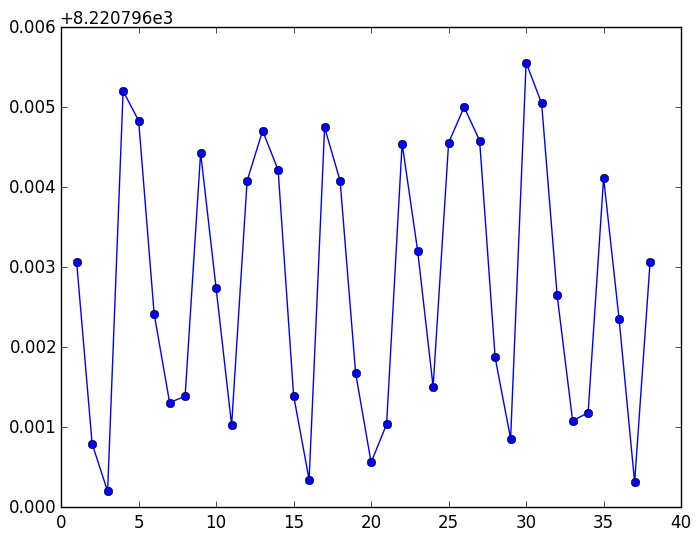

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3224c1410>

In [72]:
a1 = ones(length(time1))
b1 = zeros(length(time1))
for i=1:length(time1)
    a1[i] = i*mdt1
    b1[i] = i
end

plot(b1,time1 .- a1, "o-")

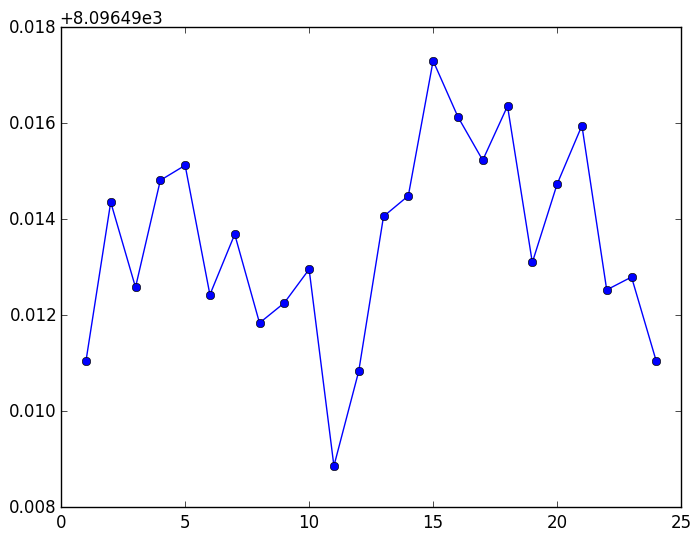

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3226f25d0>

In [73]:
a2 = ones(length(time2))
b2 = zeros(length(time2))
for i=1:length(time2)
    a2[i] = i*mdt2
    b2[i] = i
end

plot(b2,time2 .- a2, "o-")

# Wrapper for `compute_ttv.jl`

In [5]:
include("../compute_ttv.jl")

TTVFaster

In [6]:
#planet1
MpMs1 = 0.01
P1 = 10.0
t01 = 1.0
esw1 = 0.5
ecw1 = 0.5

p1 = TTVFaster.Planet_plane_hk(MpMs1, P1, t01, esw1, ecw1)

TTVFaster.Planet_plane_hk{Float64}(0.01,10.0,1.0,0.5,0.5)

In [14]:
#planet2
MpMs2 = 0.01
P2 = 100.0
t02 = 1.0
esw2 = 0.5
ecw2 = 0.5

p2 = TTVFaster.Planet_plane_hk(MpMs2, P2, t02, esw2, ecw2)

TTVFaster.Planet_plane_hk{Float64}(0.01,100.0,1.0,0.5,0.5)

In [12]:
ttv1 = zeros(length(time1));
ttv2 = zeros(length(time2));

In [17]:
TTVFaster.compute_ttv!(3, p1, p2, time1, time2, ttv1, ttv2)

In [19]:
function ttv_model(time1::Array{Float64, 1}, time2::Array{Float64, 1}, params::Vector)
    
    # Planet 1 params
    MpMs1 = params[1]
    P1    = params[2]
    t01   = params[3]
    esw1  = params[4]
    ecw1  = params[5]
    
    # Planet 2 params
    MpMs2 = params[6]
    P2    = params[7]
    t02   = params[8]
    esw2  = params[9]
    ecw2  = params[10]
    
    # System params
    jmax  = params[11] 
    
    # Create Planet type for inner planet
    planet1 = TTVFaster.Planet_plane_hk(MpMs1, P1, t01, esw1, ecw1)
    
    # Create Planet type for outer planet
    planet2 = TTVFaster.Planet_plane_hk(MpMs2, P2, t02, esw2, ecw2)
    
    # Allocate memory for ttv's
    ttv1 = zeros(length(time1));
    ttv2 = zeros(length(time2));
    
    # Call compute_ttv! Note: modifies ttv1, ttv2 in place
    TTVFaster.compute_ttv!(jmax, planet1, planet2, time1, time2, ttv1, ttv2)

    return ttv1, ttv2
end 

ttv_model (generic function with 1 method)

In [28]:
dt1 = time1[2:end] - time1[1:end-1];
dt2 = time2[2:end] - time2[1:end-1];

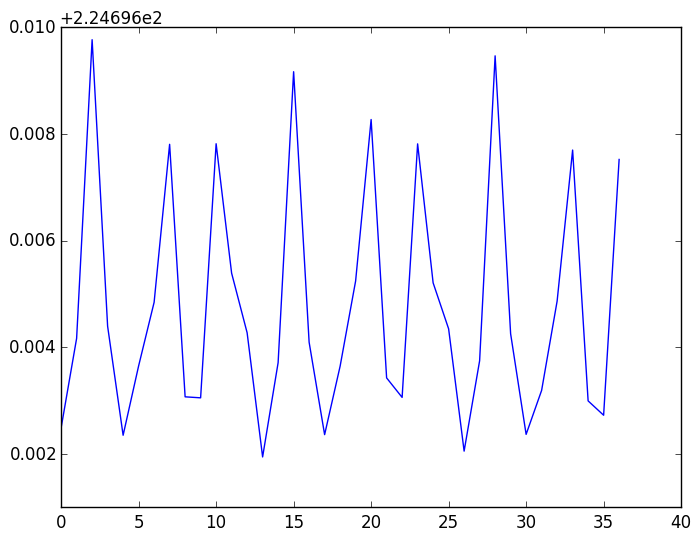

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32032eed0>

In [31]:
plot(dt1)

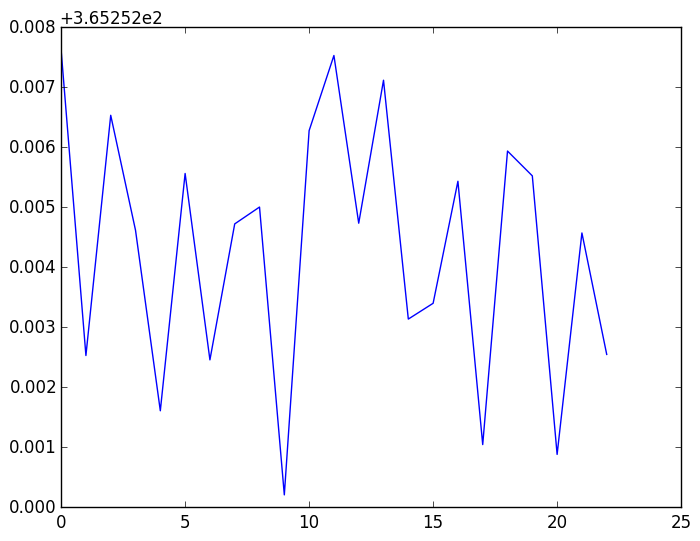

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x320436310>

In [32]:
plot(dt2)